<a href="https://colab.research.google.com/github/jcandane/RTMD/blob/main/BOMD_pyscf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyscf 

     |████████████████████████████████| 37.5 MB 7.2 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyscf
from pyscf import scf, gto, grad
from pyscf import tdscf, dft, tddft
from tqdm import tqdm

plt.style.use("dark_background")

Å = 1.889726125 ## Ångström in Bohr Radius 
π = np.pi

def convert(Z, R_ix):

    out = ""
    for i in range(len(Z)): ###
        out += str(Z[i]) + " " + str(R_ix[i,0]) + " " + str(R_ix[i,1]) + " " + str(R_ix[i,2]) + "; "

    out = out[:-2]
    return out

def get_ω(time):
    dtt = time[1] - time[0]
    return 2*π * np.linspace(0.0, 1.0/(2.0*dtt), int(len(time)/2))

def frequency(dynamicst, dynamicsrun):
    freq   = get_ω(dynamicst)
    freqprofile = np.abs(2.0/len(dynamicst) * (np.fft.fft( dynamicsrun, axis=0 ))[:len(dynamicst)//2])
    getmax = freq[np.argmax(freqprofile)]
    return freq, freqprofile

# Define the Molecule

In [3]:
mol = gto.Mole()
mol.atom    = '''H  0 0 0; H 0 0 0.7'''
mol.basis   = "sto-3g" #"cc-pvdz" ## "sto-3g"
mol.charge  = 0
mol.spin    = 0 
mol.verbose = 0
mol.build()

# BOMD/MF-level

In [29]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)

dT   = 5.0
time = np.arange(0., 4400., dT)

Z_i  = np.array([7, 7])
R_ix = mol.atom_coords() ## in bohr
v_ix = np.array([[0.,0.,-0.1],[0.,0.,0.1]])*0.
a_ix = np.zeros(R_ix.shape)

R_tix = np.zeros((time.shape[0], R_ix.shape[0], R_ix.shape[1]))
for T in tqdm(range(len(time))):
    R_tix[T] = R_ix/Å
    R_ix += v_ix * dT + a_ix * dT*dT/2

    mol.build( atom = convert(Z_i, R_ix/Å) ) 
    mf    = scf.UHF(mol).run()
    D_sαβ = mf.make_rdm1()
    F_sαβ = mf.get_fock()
    A_ix  = -grad.UHF(mf).kernel()/(1836*mol.atom_mass_list()[:,None])

    v_ix += ( a_ix + A_ix ) * dT/2
    a_ix  = A_ix

100%|██████████| 880/880 [01:55<00:00,  7.61it/s]


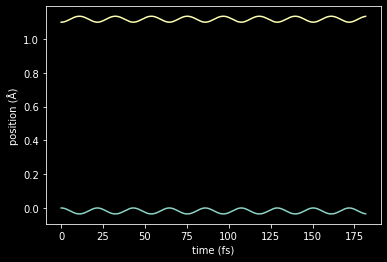

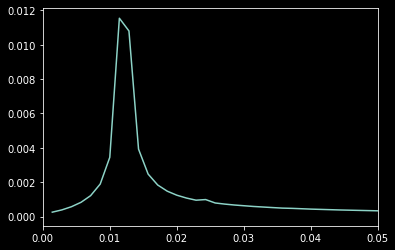

In [30]:
plt.plot(time/24.2, R_tix[:,0,2])
plt.plot(time/24.2, R_tix[:,1,2])
plt.ylabel("position (Å)")
plt.xlabel("time (fs)")
plt.show()

f, S = frequency(time, R_tix[:,0,2])

### https://www.chem.purdue.edu/gchelp/vibs/h2.html
plt.plot(f[1:], S[1:])
plt.xlim([0,0.05])
plt.show()

# Let's now do LR-MF (LR-KS)

https://pyscf.org/user/tddft.html

In [6]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)

mytd = mol.UKS().run().TDDFT().run()

dT   = 5.0
time = np.arange(0., 1440., dT)

Z_i  = np.array([7, 7])
R_ix = mol.atom_coords() ## already in Bohr!
v_ix = np.zeros(R_ix.shape)
a_ix = np.zeros(R_ix.shape)

R_tix = np.zeros((time.shape[0], R_ix.shape[0], R_ix.shape[1]))
for T in tqdm(range(len(time))):
    R_tix[T] = R_ix/Å
    R_ix += v_ix * dT + a_ix * dT*dT/2

    mol.build( atom = convert(Z_i, R_ix/Å) ) 
    mf    = dft.UKS(mol).run()
    mytd = tddft.TDDFT(mf)
    #mytd.nstates = 10
    mytd.kernel()
    D_sαβ = mf.make_rdm1()
    F_sαβ = mf.get_fock()
    A_ix  = -pyscf.grad.tduks.Gradients(mytd).kernel()/(1836*mol.atom_mass_list()[:,None])
    ##A_ix  = -grad.UHF(mf).kernel()/(1836*mol.atom_mass_list()[:,None]) ### need LRKS gradients!!! not UHF ones!!

    v_ix += ( a_ix + A_ix ) * dT/2
    a_ix  = A_ix

100%|██████████| 288/288 [06:16<00:00,  1.31s/it]


In [7]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)
mol.atom_coords() ## already in Bohr!

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 2.07869874]])

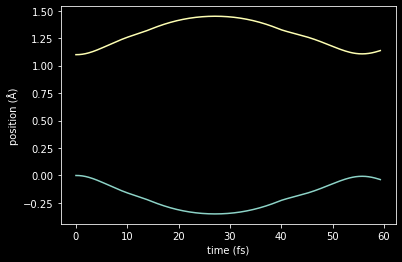

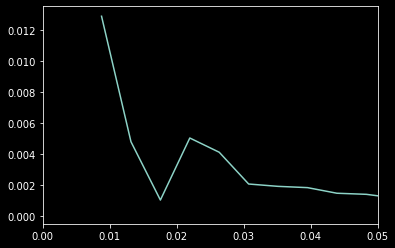

In [8]:
plt.plot(time/24.2, R_tix[:,0,2])
plt.plot(time/24.2, R_tix[:,1,2])
plt.ylabel("position (Å)")
plt.xlabel("time (fs)")
plt.show()

f, S = frequency(time, R_tix[:,0,2])

### https://www.chem.purdue.edu/gchelp/vibs/h2.html
plt.plot(f[2:], S[2:])
plt.xlim([0,0.05])
plt.show()

# post-MF gradients, examples

https://pyscf.org/user/ci.html

In [9]:
from pyscf import grad
mol = pyscf.M(
    atom = 'N 0 0 0; N 0 0 1.1',
    verbose=0,
    basis = 'ccpvdz')

mf   = mol.UHF() #.run()
mf.run()
mycc = mf.CISD().run()
print('UCISD correlation energy', mycc.e_corr)

mf    = scf.UHF(mol).run()
print("UHF force")
print( grad.UHF(mf).kernel() )

mf    = dft.UKS(mol).run()
mytd = tddft.TDDFT(mf)
#mytd.nstates = 10
mytd.kernel()
print("LRKS force")
print( pyscf.grad.tduks.Gradients(mytd).kernel() )
#A_ix  = -grad.mycc/(1836*mol.atom_mass_list()[:,None])
#pyscf.grad.cisd.Gradients(mycc).kernel()

### CISD Gradient
from pyscf import ci
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)
ci_scanner = ci.CISD(scf.RHF(mol)).nuc_grad_method().as_scanner()
e_tot, f_ix = ci_scanner(gto.M(atom="N 0 0 0; N 0 0 1.1"))
print("CISD force")
print(f_ix)

### CASCI Gradient
from pyscf import mcscf
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)
mc_grad_scanner = mcscf.CASCI(scf.RHF(mol), 4, 4).nuc_grad_method().as_scanner()
etot, f_ix = mc_grad_scanner(gto.M(atom="N 0 0 0; N 0 0 1.1"))
print("CASCI force")
print(f_ix)

### CASSCF Gradient
from pyscf import mcscf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)
mc_grad_scanner = mcscf.CASSCF(scf.RHF(mol), 4, 4).nuc_grad_method().as_scanner()
etot, f_ix = mc_grad_scanner(gto.M(atom="N 0 0 0; N 0 0 1.1"))

print("CASSCF force")
print(f_ix)

### CCSD Gradient
from pyscf import cc
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)
cc_scanner = cc.CCSD(scf.RHF(mol)).nuc_grad_method().as_scanner()
e_tot, f_ix = cc_scanner(gto.M(atom="N 0 0 0; N 0 0 1.1"))
print("CCSD force")
print(f_ix)

UCISD correlation energy -0.29226896775787803
UHF force
[[-1.15968110e-16 -8.20577904e-17 -8.01025414e-02]
 [ 1.15968110e-16  8.20577904e-17  8.01025414e-02]]
LRKS force
[[-1.44166985e-15  4.59522660e-16  2.79908871e-01]
 [ 2.15799501e-15 -4.18107303e-16 -2.79908871e-01]]
CISD force
[[ 1.34827728e-17  4.37889475e-16  2.63813652e-01]
 [-1.34827728e-17 -4.37889475e-16 -2.63813652e-01]]
CASCI force
[[ 2.45364715e-17 -9.96128231e-18  1.89269563e-01]
 [-2.45364715e-17  9.96128231e-18 -1.89269563e-01]]
CASSCF force
[[-1.67292817e-08 -2.14702947e-08  1.89914506e-01]
 [ 1.67292817e-08  2.14702947e-08 -1.89914506e-01]]
CCSD force
[[-5.88539236e-18  7.76493641e-16  2.84131282e-01]
 [ 5.88539236e-18 -7.76493641e-16 -2.84131282e-01]]


In [11]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis = '631g', verbose=0)

## hf calculation
#myhf = mol.ROHF().run() #
myhf = mol.RHF().run()
mf   = mol.UHF().run()
f_ix = grad.UHF(mf).kernel()
print(f_ix)

##### LR Theory
mff  = dft.UKS(mol).run()
mytd = tddft.TDDFT(mff)
#mytd.nstates = 10
mytd.kernel()
f_ix = mytd.nuc_grad_method().grad()
print(f_ix)

##### Do the CASSCF
ncas, nelecas = (6,(5,3))
mycas = myhf.CASSCF(4, 4).run() ### CASSCF(ncas, nelecas)
f_ix  = mycas.Gradients().grad()
print(f_ix)

##### Do the CASCI
mycasci = myhf.CASCI(4,4).run()
f_ix    = mycasci.Gradients().grad()
print(f_ix)

##### Do the CISD
myci = mf.CISD().run()
f_ix = myci.Gradients().grad()
print(f_ix)

##### Do the CCSD
mycc = mf.CCSD().run()
f_ix = myci.Gradients().grad()
print(f_ix)

[[-1.04349260e-16 -2.92611174e-17 -3.71669383e-02]
 [ 1.04349260e-16  2.92611174e-17  3.71669383e-02]]
[[-6.20565562e-16  3.11410825e-16  3.16293972e-01]
 [-2.90581318e-16  4.54055095e-16 -3.16293972e-01]]
[[ 2.82343744e-14  1.79795391e-14  4.60114873e-02]
 [-2.82343744e-14 -1.79795391e-14 -4.60114873e-02]]
[[-1.39123496e-17  1.60182374e-17  6.19053314e-02]
 [ 1.39123496e-17 -1.60182374e-17 -6.19053314e-02]]
[[-1.29063473e-16  1.16752168e-18  6.01788321e-02]
 [ 1.29063473e-16 -1.16752168e-18 -6.01788321e-02]]
[[-1.29063473e-16  1.16752168e-18  6.01788321e-02]
 [ 1.29063473e-16 -1.16752168e-18 -6.01788321e-02]]


# BOMD: CISD

In [15]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)

dT   = 5.0
time = np.arange(0., 1440., dT)

Z_i  = np.array([7, 7])
R_ix = mol.atom_coords() ## already in Bohr!
v_ix = np.zeros(R_ix.shape)
a_ix = np.zeros(R_ix.shape)

R_tix = np.zeros((time.shape[0], R_ix.shape[0], R_ix.shape[1]))
for T in tqdm(range(len(time))):
    R_tix[T] = R_ix/Å
    R_ix += v_ix * dT + a_ix * dT*dT/2

    mol.build( atom = convert(Z_i, R_ix/Å) )
    mf   = mol.UHF().run()
    myci = mf.CISD().run()

    D_sαβ = mf.make_rdm1()
    F_sαβ = mf.get_fock()
    A_ix  = -myci.Gradients().grad()/(1836*mol.atom_mass_list()[:,None])
    ##A_ix  = -grad.UHF(mf).kernel()/(1836*mol.atom_mass_list()[:,None]) ### need LRKS gradients!!! not UHF ones!!

    v_ix += ( a_ix + A_ix ) * dT/2
    a_ix  = A_ix

100%|██████████| 288/288 [01:23<00:00,  3.44it/s]


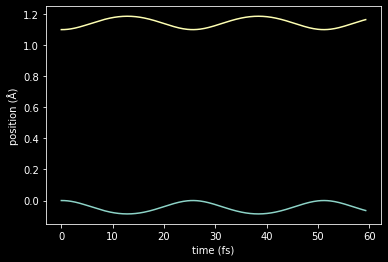

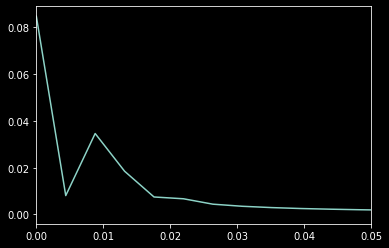

In [16]:
plt.plot(time/24.2, R_tix[:,0,2])
plt.plot(time/24.2, R_tix[:,1,2])
plt.ylabel("position (Å)")
plt.xlabel("time (fs)")
plt.show()

f, S = frequency(time, R_tix[:,0,2])

### https://www.chem.purdue.edu/gchelp/vibs/h2.html
plt.plot(f, S)
plt.xlim([0,0.05])
plt.show()

# BOMD: CASCI

In [18]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)

dT   = 5.0
time = np.arange(0., 1440., dT)

Z_i  = np.array([7, 7])
R_ix = mol.atom_coords() ## already in Bohr!
v_ix = np.zeros(R_ix.shape)
a_ix = np.zeros(R_ix.shape)

R_tix = np.zeros((time.shape[0], R_ix.shape[0], R_ix.shape[1]))
for T in tqdm(range(len(time))):
    R_tix[T] = R_ix/Å
    R_ix += v_ix * dT + a_ix * dT*dT/2

    mol.build( atom = convert(Z_i, R_ix/Å) )
    myhf   = mol.RHF().run()
    mycasci = myhf.CASCI(4,4).run()

    D_sαβ = mf.make_rdm1()
    F_sαβ = mf.get_fock()
    A_ix  = -mycasci.Gradients().grad()/(1836*mol.atom_mass_list()[:,None])
    ##A_ix  = -grad.UHF(mf).kernel()/(1836*mol.atom_mass_list()[:,None]) ### need LRKS gradients!!! not UHF ones!!

    v_ix += ( a_ix + A_ix ) * dT/2
    a_ix  = A_ix

100%|██████████| 288/288 [00:40<00:00,  7.16it/s]


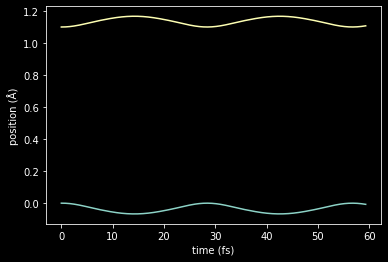

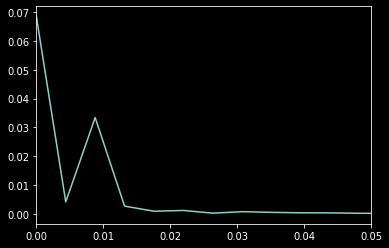

In [19]:
plt.plot(time/24.2, R_tix[:,0,2])
plt.plot(time/24.2, R_tix[:,1,2])
plt.ylabel("position (Å)")
plt.xlabel("time (fs)")
plt.show()

f, S = frequency(time, R_tix[:,0,2])

### https://www.chem.purdue.edu/gchelp/vibs/h2.html
plt.plot(f, S)
plt.xlim([0,0.05])
plt.show()

# BOMD: CASSCF

In [20]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)

dT   = 5.0
time = np.arange(0., 1440., dT)

Z_i  = np.array([7, 7])
R_ix = mol.atom_coords() ## already in Bohr!
v_ix = np.zeros(R_ix.shape)
a_ix = np.zeros(R_ix.shape)

R_tix = np.zeros((time.shape[0], R_ix.shape[0], R_ix.shape[1]))
for T in tqdm(range(len(time))):
    R_tix[T] = R_ix/Å
    R_ix += v_ix * dT + a_ix * dT*dT/2

    mol.build( atom = convert(Z_i, R_ix/Å) )
    myhf   = mol.RHF().run()
    ncas, nelecas = (6,(5,3))
    mycas = myhf.CASSCF(4, 4).run() ### CASSCF(ncas, nelecas)

    D_sαβ = mf.make_rdm1()
    F_sαβ = mf.get_fock()
    A_ix  = -mycas.Gradients().grad()/(1836*mol.atom_mass_list()[:,None])
    ##A_ix  = -grad.UHF(mf).kernel()/(1836*mol.atom_mass_list()[:,None]) ### need LRKS gradients!!! not UHF ones!!

    v_ix += ( a_ix + A_ix ) * dT/2
    a_ix  = A_ix

100%|██████████| 288/288 [07:13<00:00,  1.50s/it]


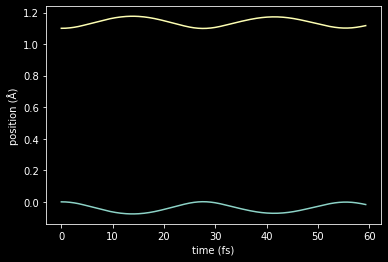

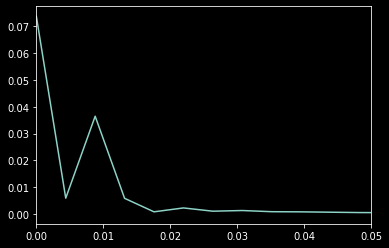

In [21]:
plt.plot(time/24.2, R_tix[:,0,2])
plt.plot(time/24.2, R_tix[:,1,2])
plt.ylabel("position (Å)")
plt.xlabel("time (fs)")
plt.show()

f, S = frequency(time, R_tix[:,0,2])

### https://www.chem.purdue.edu/gchelp/vibs/h2.html
plt.plot(f, S)
plt.xlim([0,0.05])
plt.show()

# BOMD: CCSD

In [22]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", verbose=0)

dT   = 5.0
time = np.arange(0., 1440., dT)

Z_i  = np.array([7, 7])
R_ix = mol.atom_coords() ## already in Bohr!
v_ix = np.zeros(R_ix.shape)
a_ix = np.zeros(R_ix.shape)

R_tix = np.zeros((time.shape[0], R_ix.shape[0], R_ix.shape[1]))
for T in tqdm(range(len(time))):
    R_tix[T] = R_ix/Å
    R_ix += v_ix * dT + a_ix * dT*dT/2

    mol.build( atom = convert(Z_i, R_ix/Å) )
    mf   = mol.UHF().run()
    mycc = mf.CCSD().run()

    D_sαβ = mf.make_rdm1()
    F_sαβ = mf.get_fock()
    A_ix  = -mycc.Gradients().grad()/(1836*mol.atom_mass_list()[:,None])

    v_ix += ( a_ix + A_ix ) * dT/2
    a_ix  = A_ix

100%|██████████| 288/288 [02:26<00:00,  1.96it/s]


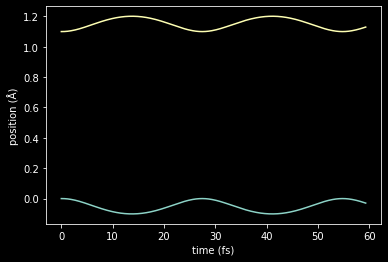

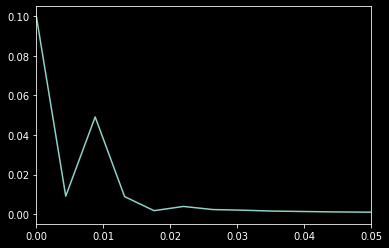

In [23]:
plt.plot(time/24.2, R_tix[:,0,2])
plt.plot(time/24.2, R_tix[:,1,2])
plt.ylabel("position (Å)")
plt.xlabel("time (fs)")
plt.show()

f, S = frequency(time, R_tix[:,0,2])

### https://www.chem.purdue.edu/gchelp/vibs/h2.html
plt.plot(f, S)
plt.xlim([0,0.05])
plt.show()